### Import all the packages

In [1]:
import pandas as pd
import nltk
import numpy as np
from numpy import random as npr
import time
import string
import sklearn
import random
# from itertools import chain, imap

In [2]:
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


In [3]:
# download stopwords and punctuations 
nltk.download('punkt') 
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/dhmjoe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dhmjoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import re
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
#from operator import itemgetter

### Data Processing

In [5]:
#Read in data
df1 = pd.read_json('/Users/dhmjoe/Desktop/carpe data Haoming/final_50k_221118.json',lines=True)

In [6]:
df_shuffled = df1.sample(frac=1, random_state=39)

# Reset the index
df_shuffled = df_shuffled.reset_index(drop=True)

# Select first 30000 rows from the shuffled data set
df_30 = df_shuffled[0:100000]

# Regroup the df_30 dat set with unique business id
df_new = df_30.groupby(df_30["awesome_biz_id"],as_index=False).agg({"content":' '.join,"business_name":"first","is_entertainment":"first","is_traffic":"first"})

# Define the label
label = ["is_entertainment","is_traffic"]

# Extract the labels
labeldf = df_new[["is_entertainment","is_traffic"]]

# Extract "business name" and "content" columns
df2 = df_new[["business_name","content"]]


### Train/Test Split

In [7]:
df2_train, df2_test = train_test_split(df2, test_size=0.2, random_state=434)
df2_train = df2_train.reset_index()
df2_test = df2_test.reset_index()

### Tokenize Data

In [8]:
token = []
name = ["business_name","content"]
dic1 = {}
WORD = re.compile(r'\w+')


token = []
name = ["business_name","content"]
dic_train = {}
dic_test = {}
WORD = re.compile(r'\w+')


In [9]:
def regTokenize(text):
    words = WORD.findall(text)
    return words

In [11]:
# train
for i in [0,1]:
    arrx = []
    for j in range(0,len(df2_train)):
    #for j in range(0,len(df2[name[i]])):
        listx = regTokenize(df2_train[name[i]][j])
        arrx.append(listx)
    dic_train[name[i]] = arrx

# test 
for i in [0,1]:
    arrx = []
    for j in range(0,len(df2_test)):
    #for j in range(0,len(df2[name[i]])):
        listx = regTokenize(df2_test[name[i]][j])
        arrx.append(listx)
    dic_test[name[i]] = arrx   

### Stop words

In [12]:
stop_words = set(stopwords.words("english"))
for i in range(len(string.punctuation)):    
    stop_words.add(string.punctuation[i])
stop_words.add("'s")
stop_words.add(".....")
print(stop_words)

{"it's", 'some', 'during', 'didn', 'there', 'than', "wasn't", '"', 'most', "you'll", 'where', 'their', 'her', 'which', 'only', 'such', 's', 'down', "mightn't", 'needn', '.', 'we', 'myself', 'mustn', 'wasn', '%', 'under', 'haven', 'not', "shan't", 'that', 'with', 'have', 'him', 'itself', 'mightn', 'having', 'so', "weren't", 'against', "isn't", 'out', 'both', 'did', 'on', 'an', 'each', 'should', 'is', "haven't", 'won', "mustn't", 'just', 'does', 'by', '[', 'this', 'has', 'was', 'shan', 'were', 't', "she's", '-', 'few', 'the', 'too', 'can', 'doesn', 'couldn', 'those', 'ourselves', 'will', '.....', '\\', 'up', 'whom', '`', 'as', 'a', 'i', 'here', 'themselves', 'at', '$', 'above', '+', '}', 'until', 'because', "'s", 'his', 'very', 'yourselves', 'm', 'further', 'being', 'ma', 'they', ':', 'if', 'off', 'what', '~', 'all', 'hers', 'o', 'it', 've', 'isn', '<', '^', '!', 'but', 'or', 'while', 'for', 'aren', '(', 'wouldn', 'my', "hadn't", 'weren', "should've", 'he', "that'll", 'shouldn', "shouldn

### Word Stemmer

In [13]:
stemmer = PorterStemmer()

# train
for i in [0,1]:
    arrc = []
    for j in range(0,len(dic_train[name[i]])):
        flist = []
        for z in dic_train[name[i]][j]:
            if z.casefold() not in stop_words:
                flist.append(stemmer.stem(z))
        arrc.append(' '.join(flist))
    dic_train[name[i]] = arrc
    
# test
for i in [0,1]:
    arrc = []
    for j in range(0,len(dic_test[name[i]])):
        flist = []
        for z in dic_test[name[i]][j]:
            if z.casefold() not in stop_words:
                flist.append(stemmer.stem(z))
        arrc.append(' '.join(flist))
    dic_test[name[i]] = arrc
      


### TF-IDF without NMF/SVD (combining content and business name,threshold=0.001)

In [66]:
# train tf-idf
tf_idf_model_train_01  = TfidfVectorizer(min_df=0.001,max_features=360)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_train["business_name"]
tf_idf_vector1 = tf_idf_model_train_01.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_train_01  = TfidfVectorizer(min_df=0.001,max_features=3320)
contf = dic_train["content"]
tf_idf_vector2 = tf_idf_model_train_01.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_train_01 = X_01
print(df_wt_nmf_train_01)
print(len(df_wt_nmf_train_01[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 3692 - 363 - 3329

# test tf-idf
tf_idf_model_test_01  = TfidfVectorizer(min_df=0.001,max_features=360)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_test["business_name"]
tf_idf_vector1 = tf_idf_model_test_01.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_test_01  = TfidfVectorizer(min_df=0.001,max_features=3320)
contf = dic_test["content"]
tf_idf_vector2 = tf_idf_model_test_01.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_test_01 = X_01
print(df_wt_nmf_test_01)
print(len(df_wt_nmf_test_01[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 3905 - 436 - 3469

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
3680
360
3320
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
3680
360
3320


### TF-IDF without NMF/SVD (combining content and business name,threshold=0.003)

In [67]:
# train tf-idf
tf_idf_model_train_03  = TfidfVectorizer(min_df=0.003,max_features=100)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_train["business_name"]
tf_idf_vector1 = tf_idf_model_train_03.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_train_03  = TfidfVectorizer(min_df=0.003,max_features=1660)
contf = dic_train["content"]
tf_idf_vector2 = tf_idf_model_train_03.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_train_03 = X_01
print(df_wt_nmf_train_03)
print(len(df_wt_nmf_train_03[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 1784 - 115 - 1669

# test tf-idf
tf_idf_model_test_03  = TfidfVectorizer(min_df=0.003,max_features=100)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_test["business_name"]
tf_idf_vector1 = tf_idf_model_test_03.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_test_03  = TfidfVectorizer(min_df=0.003,max_features=1660)
contf = dic_test["content"]
tf_idf_vector2 = tf_idf_model_test_03.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_test_03 = X_01
print(df_wt_nmf_test_03)
print(len(df_wt_nmf_test_03[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 1797 - 108 - 1689

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1760
100
1660
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1760
100
1660


### TF-IDF without NMF/SVD (combining content and business name,threshold=0.005)

In [68]:
# train tf-idf
tf_idf_model_train_05  = TfidfVectorizer(min_df=0.005,max_features=55)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_train["business_name"]
tf_idf_vector1 = tf_idf_model_train_05.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_train_05  = TfidfVectorizer(min_df=0.005,max_features=1210)
contf = dic_train["content"]
tf_idf_vector2 = tf_idf_model_train_05.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_train_05 = X_01
print(df_wt_nmf_train_05)
print(len(df_wt_nmf_train_05[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 1276 - 58 - 1218

# test tf-idf
tf_idf_model_test_05  = TfidfVectorizer(min_df=0.005,max_features=55)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_test["business_name"]
tf_idf_vector1 = tf_idf_model_test_05.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_test_05  = TfidfVectorizer(min_df=0.005,max_features=1210)
contf = dic_test["content"]
tf_idf_vector2 = tf_idf_model_test_05.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_test_05 = X_01
print(df_wt_nmf_test_05)
print(len(df_wt_nmf_test_05[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 1293 - 62 - 1231

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1265
55
1210
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1265
55
1210


### TF-IDF without NMF/SVD (combining content and business name,threshold=0.010)

In [69]:
# train tf-idf
tf_idf_model_train_10  = TfidfVectorizer(min_df=0.01,max_features=25)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_train["business_name"]
tf_idf_vector1 = tf_idf_model_train_10.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_train_10  = TfidfVectorizer(min_df=0.01,max_features=730)
contf = dic_train["content"]
tf_idf_vector2 = tf_idf_model_train_10.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_train_10 = X_01
print(df_wt_nmf_train_10)
print(len(df_wt_nmf_train_10[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 758 - 26 -732

# test tf-idf
tf_idf_model_test_10  = TfidfVectorizer(min_df=0.01,max_features=25)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_test["business_name"]
tf_idf_vector1 = tf_idf_model_test_10.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_test_10  = TfidfVectorizer(min_df=0.01,max_features=730)
contf = dic_test["content"]
tf_idf_vector2 = tf_idf_model_test_10.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_test_10 = X_01
print(df_wt_nmf_test_10)
print(len(df_wt_nmf_test_10[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 761 - 25 - 736

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
755
25
730
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
755
25
730


### TF-IDF without NMF/SVD (combining content and business name,threshold=0.015)

In [78]:
# train tf-idf
tf_idf_model_train_15  = TfidfVectorizer(min_df=0.015,max_features=12)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_train["business_name"]
tf_idf_vector1 = tf_idf_model_train_15.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_train_15  = TfidfVectorizer(min_df=0.015,max_features=500)
contf = dic_train["content"]
tf_idf_vector2 = tf_idf_model_train_15.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_train_15 = X_01
print(df_wt_nmf_train_15)
print(len(df_wt_nmf_train_15[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 520 - 15 - 505

# test tf-idf
tf_idf_model_test_15  = TfidfVectorizer(min_df=0.015,max_features=12)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_test["business_name"]
tf_idf_vector1 = tf_idf_model_test_15.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_test_15  = TfidfVectorizer(min_df=0.015,max_features=500)
contf = dic_test["content"]
tf_idf_vector2 = tf_idf_model_test_15.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_test_15 = X_01
print(df_wt_nmf_test_15)
print(len(df_wt_nmf_test_15[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 529 - 14 - 515

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
512
12
500
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
512
12
500


### TF-IDF without NMF/SVD (combining content and business name,threshold=0.020)

In [82]:
# train tf-idf
tf_idf_model_train_20  = TfidfVectorizer(min_df=0.02,max_features=9)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_train["business_name"]
tf_idf_vector1 = tf_idf_model_train_20.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_train_20  = TfidfVectorizer(min_df=0.02,max_features=375)
contf = dic_train["content"]
tf_idf_vector2 = tf_idf_model_train_20.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_train_20 = X_01
print(df_wt_nmf_train_20)
print(len(df_wt_nmf_train_20[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 386 - 9 - 377

# test tf-idf
tf_idf_model_test_20  = TfidfVectorizer(min_df=0.02,max_features=9)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_test["business_name"]
tf_idf_vector1 = tf_idf_model_test_20.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_test_20  = TfidfVectorizer(min_df=0.02,max_features=375)
contf = dic_test["content"]
tf_idf_vector2 = tf_idf_model_test_20.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_test_20 = X_01
print(df_wt_nmf_test_20)
print(len(df_wt_nmf_test_20[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 402 - 10 - 392

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.14940548 0.         0.        ]
 [0.         0.         0.         ... 0.11012629 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05965279 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.11416937 0.         0.        ]]
384
9
375
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.08961911 0.15236261 0.        ]]
384
9
375


### TF-IDF without NMF/SVD (combining content and business name,threshold=0.025)

In [85]:
# train tf-idf
tf_idf_model_train_25  = TfidfVectorizer(min_df=0.025,max_features=5)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_train["business_name"]
tf_idf_vector1 = tf_idf_model_train_25.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_train_25  = TfidfVectorizer(min_df=0.025,max_features=300)
contf = dic_train["content"]
tf_idf_vector2 = tf_idf_model_train_25.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_train_25 = X_01
print(df_wt_nmf_train_25)
print(len(df_wt_nmf_train_25[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 308 - 5 -303

# test tf-idf
tf_idf_model_test_25  = TfidfVectorizer(min_df=0.025,max_features=5)
#print(tf_idf_model.get_feature_names_out())
bustf = dic_test["business_name"]
tf_idf_vector1 = tf_idf_model_test_25.fit_transform(bustf)
tf_idf_array1 = tf_idf_vector1.toarray()
#print(tf_idf_model.get_feature_names_out())
tf_idf_model_test_25  = TfidfVectorizer(min_df=0.025,max_features=300)
contf = dic_test["content"]
tf_idf_vector2 = tf_idf_model_test_25.fit_transform(contf)
tf_idf_array2 = tf_idf_vector2.toarray()
#words_set = tf_idf_model.get_feature_names_out()
#print(words_set)
# TF-IDF without NMF
X_01 = np.hstack((tf_idf_array1,tf_idf_array2))
df_wt_nmf_test_25 = X_01
print(df_wt_nmf_test_25)
print(len(df_wt_nmf_test_25[1]))
print(len(tf_idf_array1[1]))
print(len(tf_idf_array2[1]))
# 318 - 6 - 312

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.16858101 0.        ]
 [0.         0.         0.         ... 0.         0.11849025 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.06852157 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.11573253 0.        ]]
305
5
300
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.10525892 0.        ]]
305
5
300


### Precision Recall Curve for all models

#### import all library

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import precision_recall_curve as prc

### tune: KNN, Decision Tree, Naive Bayes
### not tune: GBM, Random Forest, Logistic Regression

#### Precision-Recall Curves (threshold=0.001)

is_entertainment
Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

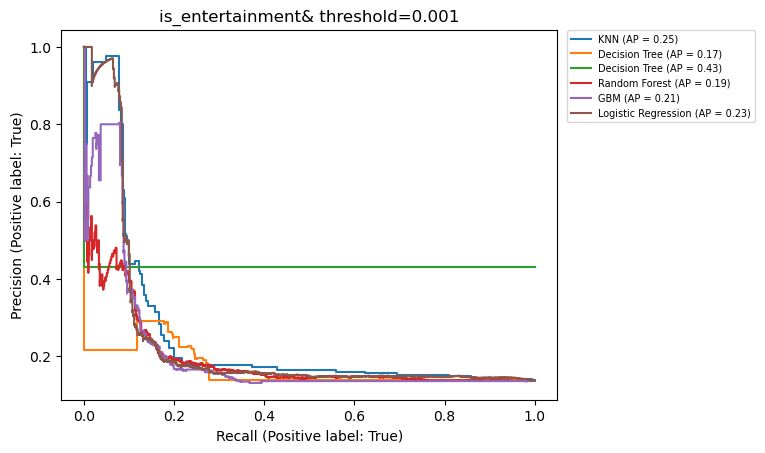

is_traffic
Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

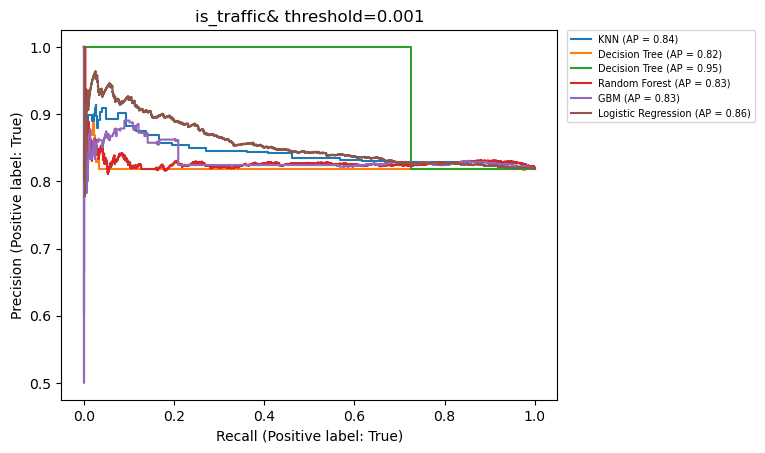

In [71]:
for j in [0,1]:
    print(label[j])
    X_train = df_wt_nmf_train_01
    X_test = df_wt_nmf_test_01
    y_train, y_test = train_test_split(labeldf[label[j]], test_size=0.2, random_state=434)
    
    # create and fit the KNN model
    '''
    ## cross validation
    knn = KNeighborsClassifier()
    k_range = list(range(1, 175))
    param_grid = dict(n_neighbors=k_range)
  
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1', return_train_score=False,verbose=1)
  
    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train)
    best_k = list(grid_search.best_params_.values())[0]
    '''
    ## fit the best knn model
    knn_best = KNeighborsClassifier(n_neighbors=175)
    knn_best.fit(X_train, y_train)

    # create and fit Decision Tree Model
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    ## grid search CV
    params = {
    'max_depth': [20, 30, 50, 100],
    'min_samples_leaf': [2,5,10,15,20],
    'min_samples_split': [2,10,20,30,40],
    'splitter' : ['best','random'],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit th best decision tree model 
    grid_search.fit(X_train, y_train)
    dt_best = grid_search.best_estimator_
    
    # create and fit the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    ## grid search CV
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    
    ## fit the best naive bayes model 
    gs_NB.fit(Data_transformed, y_test)

    # create and fit Random Forest Model
    rf_01 = RandomForestClassifier(random_state=42)
    rf_01.fit(X_train, y_train)
    
    ## grid search CV
    parameters = {
        'n_estimators': [100, 250, 500], # chose these for optimal accuracy + computation time
        'max_features': ['sqrt','log2'], 
        'max_depth': [10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=rf_01, 
                           param_grid=parameters, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit the best random forest model
    grid_search.fit(X_train, y_train)
    rf_01_best = grid_search.best_estimator_
    
    # create and fit the GBM model 
    gbm_model = GBC(n_estimators=100,learning_rate = 0.05)
    gbm_model.fit(X_train, y_train)
    
    # create and fit the Logistic Regression Model
    lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
    lr_l2.fit(X_train, y_train)
    
    """
    ## cross validation
    lr_model = LogisticRegression()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    # define search
    search = GridSearchCV(lr_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    lr_best = search.fit(X_train, y_train)
    plot_precision_recall_curve(lr_best, X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')
    """
    
    # precision/recall curve
    plot_precision_recall_curve(knn_best, X_test, y_test, ax = plt.gca(), name = 'KNN')
    plot_precision_recall_curve(dt_best, X_test, y_test, ax = plt.gca(), name = 'Decision Tree')
    plot_precision_recall_curve(gs_NB, Data_transformed, y_test, ax = plt.gca(), name = 'Naive Bayes')
    plot_precision_recall_curve(rf_01_best, X_test, y_test, ax = plt.gca(), name = 'Random Forest')
    plot_precision_recall_curve(gbm_model, X_test, y_test, ax = plt.gca(), name = 'GBM')
    plot_precision_recall_curve(lr_l2 , X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')

    plt.title(label[j]+"& threshold=0.001")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={'size': 7})
    plt.show()

#### Precision-Recall Curves (threshold=0.003)

is_entertainment
Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

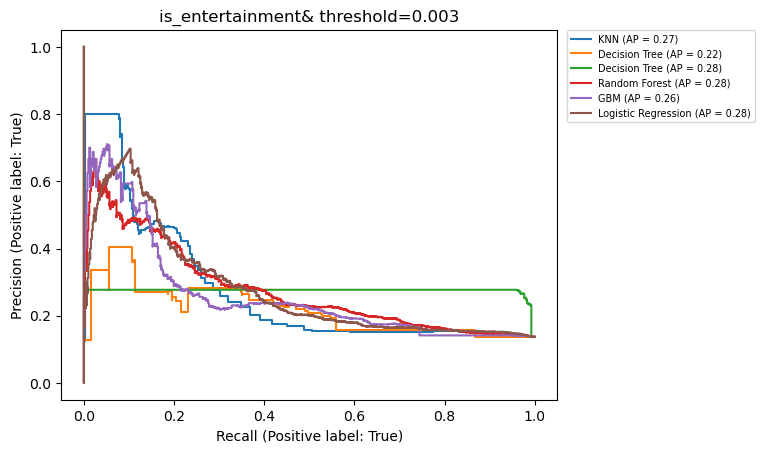

is_traffic
Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

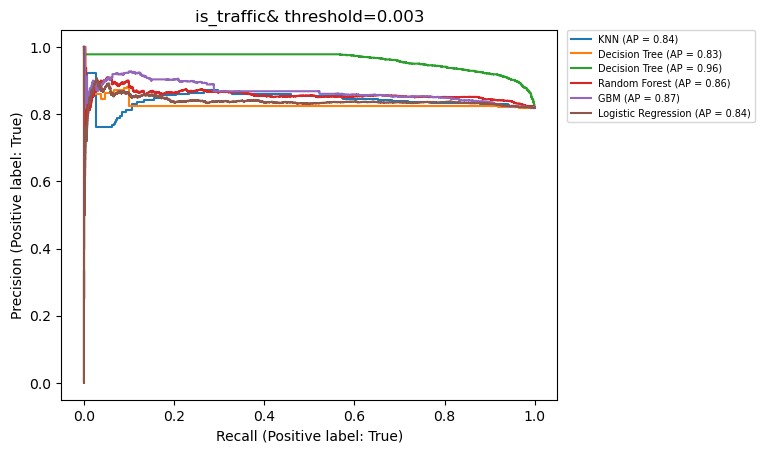

In [72]:
for j in [0,1]:
    print(label[j])
    X_train = df_wt_nmf_train_03
    X_test = df_wt_nmf_test_03
    y_train, y_test = train_test_split(labeldf[label[j]], test_size=0.2, random_state=434)
    
    # create and fit the KNN model
    '''
    ## cross validation
    knn = KNeighborsClassifier()
    k_range = list(range(1, 175))
    param_grid = dict(n_neighbors=k_range)
  
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1', return_train_score=False,verbose=1)
  
    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train)
    best_k = list(grid_search.best_params_.values())[0]
    
    '''
    ## fit the best knn model
    knn_best = KNeighborsClassifier(n_neighbors=175)
    knn_best.fit(X_train, y_train)

    # create and fit Decision Tree Model
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    ## grid search CV
    params = {
    'max_depth': [20, 30, 50, 100],
    'min_samples_leaf': [2,5,10,15,20],
    'min_samples_split': [2,10,20,30,40],
    'splitter' : ['best','random'],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit th best decision tree model 
    grid_search.fit(X_train, y_train)
    dt_best = grid_search.best_estimator_
    
    # create and fit the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    ## grid search CV
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    
    ## fit the best naive bayes model 
    gs_NB.fit(Data_transformed, y_test)

    # create and fit Random Forest Model
    rf_01 = RandomForestClassifier(random_state=42)
    rf_01.fit(X_train, y_train)
    
    ## grid search CV
    parameters = {
        'n_estimators': [100, 250, 500], # chose these for optimal accuracy + computation time
        'max_features': ['sqrt','log2'], 
        'max_depth': [10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=rf_01, 
                           param_grid=parameters, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit the best random forest model
    grid_search.fit(X_train, y_train)
    rf_01_best = grid_search.best_estimator_
    
    # create and fit the GBM model 
    gbm_model = GBC(n_estimators=100,learning_rate = 0.05)
    gbm_model.fit(X_train, y_train)
    
    # create and fit the Logistic Regression Model
    lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
    lr_l2.fit(X_train, y_train)
    """
    ## cross validation
    lr_model = LogisticRegression()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    # define search
    search = GridSearchCV(lr_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    lr_best = search.fit(X_train, y_train)
    plot_precision_recall_curve(lr_best, X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')
    """
    
    # precision/recall curve
    plot_precision_recall_curve(knn_best, X_test, y_test, ax = plt.gca(), name = 'KNN')
    plot_precision_recall_curve(dt_best, X_test, y_test, ax = plt.gca(), name = 'Decision Tree')
    plot_precision_recall_curve(gs_NB, Data_transformed, y_test, ax = plt.gca(), name = 'Naive Bayes')
    plot_precision_recall_curve(rf_01_best, X_test, y_test, ax = plt.gca(), name = 'Random Forest')
    plot_precision_recall_curve(gbm_model, X_test, y_test, ax = plt.gca(), name = 'GBM')
    plot_precision_recall_curve(lr_l2 , X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')

    plt.title(label[j]+"& threshold=0.003")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={'size': 7})
    plt.show()

#### Precision-Recall Curves (threshold=0.005)

In [73]:
for j in [0,1]:
    print(label[j])
    X_train = df_wt_nmf_train_05
    X_test = df_wt_nmf_test_05
    y_train, y_test = train_test_split(labeldf[label[j]], test_size=0.2, random_state=434)
    
    # create and fit the KNN model
    """
    ## cross validation
    knn = KNeighborsClassifier()
    k_range = list(range(1, 175))
    param_grid = dict(n_neighbors=k_range)
  
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1', return_train_score=False,verbose=1)
  
    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train)
    best_k = list(grid_search.best_params_.values())[0]
    """
    
    ## fit the best knn model
    knn_best = KNeighborsClassifier(n_neighbors=175)
    knn_best.fit(X_train, y_train)

    # create and fit Decision Tree Model
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    ## grid search CV
    params = {
    'max_depth': [20, 30, 50, 100],
    'min_samples_leaf': [2,5,10,15,20],
    'min_samples_split': [2,10,20,30,40],
    'splitter' : ['best','random'],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit th best decision tree model 
    grid_search.fit(X_train, y_train)
    dt_best = grid_search.best_estimator_
    
    # create and fit the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    ## grid search CV
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    
    ## fit the best naive bayes model 
    gs_NB.fit(Data_transformed, y_test)

    # create and fit Random Forest Model
    rf_01 = RandomForestClassifier(random_state=42)
    rf_01.fit(X_train, y_train)
    
    ## grid search CV
    parameters = {
        'n_estimators': [100, 250, 500], # chose these for optimal accuracy + computation time
        'max_features': ['sqrt','log2'], 
        'max_depth': [10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=rf_01, 
                           param_grid=parameters, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit the best random forest model
    grid_search.fit(X_train, y_train)
    rf_01_best = grid_search.best_estimator_
    
    # create and fit the GBM model 
    gbm_model = GBC(n_estimators=100,learning_rate = 0.05)
    gbm_model.fit(X_train, y_train)
    
    # create and fit the Logistic Regression Model
    lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
    lr_l2.fit(X_train, y_train)
    """
    ## cross validation
    lr_model = LogisticRegression()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    # define search
    search = GridSearchCV(lr_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    lr_best = search.fit(X_train, y_train)
    plot_precision_recall_curve(lr_best, X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')
    """
    
    # precision/recall curve
    plot_precision_recall_curve(knn_best, X_test, y_test, ax = plt.gca(), name = 'KNN')
    plot_precision_recall_curve(dt_best, X_test, y_test, ax = plt.gca(), name = 'Decision Tree')
    plot_precision_recall_curve(gs_NB, Data_transformed, y_test, ax = plt.gca(), name = 'Naive Bayes')
    plot_precision_recall_curve(rf_01_best, X_test, y_test, ax = plt.gca(), name = 'Random Forest')
    plot_precision_recall_curve(gbm_model, X_test, y_test, ax = plt.gca(), name = 'GBM')
    plot_precision_recall_curve(lr_l2 , X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')

    plt.title(label[j]+"& threshold=0.005")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={'size': 7})
    plt.show()

is_entertainment
Fitting 3 folds for each of 174 candidates, totalling 522 fits


KeyboardInterrupt: 

#### Precision-Recall Curves (threshold=0.01)

is_entertainment
Fitting 3 folds for each of 174 candidates, totalling 522 fits
Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

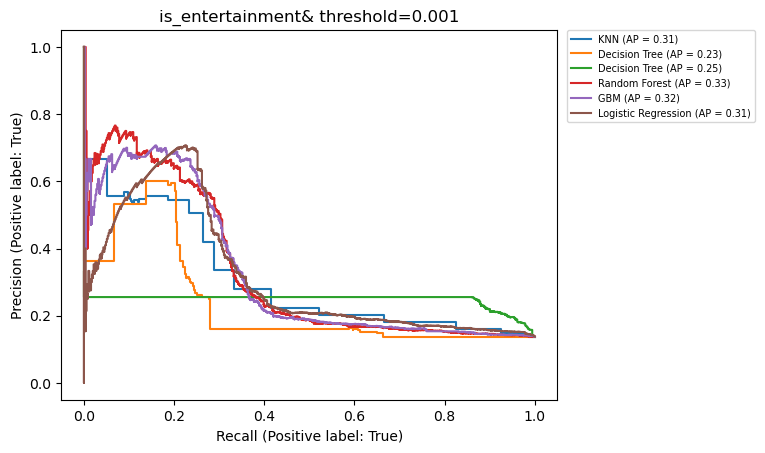

is_traffic
Fitting 3 folds for each of 174 candidates, totalling 522 fits
Fitting 3 folds for each of 800 candidates, totalling 2400 fits
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed i

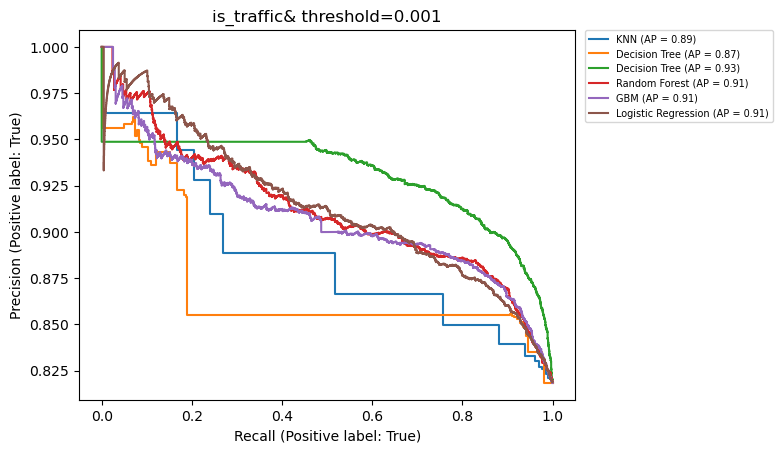

In [61]:
for j in [0,1]:
    print(label[j])
    X_train = df_wt_nmf_train_10
    X_test = df_wt_nmf_test_10
    y_train, y_test = train_test_split(labeldf[label[j]], test_size=0.2, random_state=434)
    
    # create and fit the KNN model
    '''
    ## cross validation
    knn = KNeighborsClassifier()
    k_range = list(range(1, 175))
    param_grid = dict(n_neighbors=k_range)
  
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1', return_train_score=False,verbose=1)
  
    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train)
    best_k = list(grid_search.best_params_.values())[0]
    '''
    ## fit the best knn model
    knn_best = KNeighborsClassifier(n_neighbors=175)
    knn_best.fit(X_train, y_train)

    # create and fit Decision Tree Model
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    ## grid search CV
    params = {
    'max_depth': [20, 30, 50, 100],
    'min_samples_leaf': [2,5,10,15,20],
    'min_samples_split': [2,10,20,30,40],
    'splitter' : ['best','random'],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit th best decision tree model 
    grid_search.fit(X_train, y_train)
    dt_best = grid_search.best_estimator_
    
    # create and fit the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    ## grid search CV
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    
    ## fit the best naive bayes model 
    gs_NB.fit(Data_transformed, y_test)

    # create and fit Random Forest Model
    rf_01 = RandomForestClassifier(random_state=42)
    rf_01.fit(X_train, y_train)
    
    ## grid search CV
    parameters = {
        'n_estimators': [100, 250, 500], # chose these for optimal accuracy + computation time
        'max_features': ['sqrt','log2'], 
        'max_depth': [10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=rf_01, 
                           param_grid=parameters, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit the best random forest model
    grid_search.fit(X_train, y_train)
    rf_01_best = grid_search.best_estimator_
    
    # create and fit the GBM model 
    gbm_model = GBC(n_estimators=100,learning_rate = 0.05)
    gbm_model.fit(X_train, y_train)
    
    # create and fit the Logistic Regression Model
    lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
    lr_l2.fit(X_train, y_train)
    """
    ## cross validation
    lr_model = LogisticRegression()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    # define search
    search = GridSearchCV(lr_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    lr_best = search.fit(X_train, y_train)
    plot_precision_recall_curve(lr_best, X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')
    """
    
    # precision/recall curve
    plot_precision_recall_curve(knn_best, X_test, y_test, ax = plt.gca(), name = 'KNN')
    plot_precision_recall_curve(dt_best, X_test, y_test, ax = plt.gca(), name = 'Decision Tree')
    plot_precision_recall_curve(gs_NB, Data_transformed, y_test, ax = plt.gca(), name = 'Naive Bayes')
    plot_precision_recall_curve(rf_01_best, X_test, y_test, ax = plt.gca(), name = 'Random Forest')
    plot_precision_recall_curve(gbm_model, X_test, y_test, ax = plt.gca(), name = 'GBM')
    plot_precision_recall_curve(lr_l2 , X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')

    plt.title(label[j]+"& threshold=0.010")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={'size': 7})
    plt.show()

#### Precision-Recall Curves (threshold=0.015)

In [ ]:
for j in [0,1]:
    print(label[j])
    X_train = df_wt_nmf_train_15
    X_test = df_wt_nmf_test_15
    y_train, y_test = train_test_split(labeldf[label[j]], test_size=0.2, random_state=434)
    
    # create and fit the KNN model
    '''
    ## cross validation
    knn = KNeighborsClassifier()
    k_range = list(range(1, 175))
    param_grid = dict(n_neighbors=k_range)
  
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1', return_train_score=False,verbose=1)
  
    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train)
    best_k = list(grid_search.best_params_.values())[0]
    '''
    ## fit the best knn model
    knn_best = KNeighborsClassifier(n_neighbors=175)
    knn_best.fit(X_train, y_train)

    # create and fit Decision Tree Model
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    ## grid search CV
    params = {
    'max_depth': [20, 30, 50, 100],
    'min_samples_leaf': [2,5,10,15,20],
    'min_samples_split': [2,10,20,30,40],
    'splitter' : ['best','random'],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit th best decision tree model 
    grid_search.fit(X_train, y_train)
    dt_best = grid_search.best_estimator_
    
    # create and fit the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    ## grid search CV
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    
    ## fit the best naive bayes model 
    gs_NB.fit(Data_transformed, y_test)

    # create and fit Random Forest Model
    rf_01 = RandomForestClassifier(random_state=42)
    rf_01.fit(X_train, y_train)
    
    ## grid search CV
    parameters = {
        'n_estimators': [100, 250, 500], # chose these for optimal accuracy + computation time
        'max_features': ['sqrt','log2'], 
        'max_depth': [10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=rf_01, 
                           param_grid=parameters, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit the best random forest model
    grid_search.fit(X_train, y_train)
    rf_01_best = grid_search.best_estimator_
    
    # create and fit the GBM model 
    gbm_model = GBC(n_estimators=100,learning_rate = 0.05)
    gbm_model.fit(X_train, y_train)
    
    # create and fit the Logistic Regression Model
    lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
    lr_l2.fit(X_train, y_train)
    """
    ## cross validation
    lr_model = LogisticRegression()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    # define search
    search = GridSearchCV(lr_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    lr_best = search.fit(X_train, y_train)
    plot_precision_recall_curve(lr_best, X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')
    """
    
    # precision/recall curve
    plot_precision_recall_curve(knn_best, X_test, y_test, ax = plt.gca(), name = 'KNN')
    plot_precision_recall_curve(dt_best, X_test, y_test, ax = plt.gca(), name = 'Decision Tree')
    plot_precision_recall_curve(gs_NB, Data_transformed, y_test, ax = plt.gca(), name = 'Naive Bayes')
    plot_precision_recall_curve(rf_01_best, X_test, y_test, ax = plt.gca(), name = 'Random Forest')
    plot_precision_recall_curve(gbm_model, X_test, y_test, ax = plt.gca(), name = 'GBM')
    plot_precision_recall_curve(lr_l2 , X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')

    plt.title(label[j]+"& threshold=0.015")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={'size': 7})
    plt.show()

#### Precision-Recall Curves (threshold=0.020)

In [ ]:
for j in [0,1]:
    print(label[j])
    X_train = df_wt_nmf_train_20
    X_test = df_wt_nmf_test_20
    y_train, y_test = train_test_split(labeldf[label[j]], test_size=0.2, random_state=434)
    
    # create and fit the KNN model
    '''
    ## cross validation
    knn = KNeighborsClassifier()
    k_range = list(range(1, 175))
    param_grid = dict(n_neighbors=k_range)
  
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1', return_train_score=False,verbose=1)
  
    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train)
    best_k = list(grid_search.best_params_.values())[0]
    '''
    ## fit the best knn model
    knn_best = KNeighborsClassifier(n_neighbors=175)
    knn_best.fit(X_train, y_train)

    # create and fit Decision Tree Model
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    ## grid search CV
    params = {
    'max_depth': [20, 30, 50, 100],
    'min_samples_leaf': [2,5,10,15,20],
    'min_samples_split': [2,10,20,30,40],
    'splitter' : ['best','random'],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit th best decision tree model 
    grid_search.fit(X_train, y_train)
    dt_best = grid_search.best_estimator_
    
    # create and fit the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    ## grid search CV
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    
    ## fit the best naive bayes model 
    gs_NB.fit(Data_transformed, y_test)

    # create and fit Random Forest Model
    rf_01 = RandomForestClassifier(random_state=42)
    rf_01.fit(X_train, y_train)
    
    ## grid search CV
    parameters = {
        'n_estimators': [100, 250, 500], # chose these for optimal accuracy + computation time
        'max_features': ['sqrt','log2'], 
        'max_depth': [10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=rf_01, 
                           param_grid=parameters, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit the best random forest model
    grid_search.fit(X_train, y_train)
    rf_01_best = grid_search.best_estimator_
    
    # create and fit the GBM model 
    gbm_model = GBC(n_estimators=100,learning_rate = 0.05)
    gbm_model.fit(X_train, y_train)
    
    # create and fit the Logistic Regression Model
    lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
    lr_l2.fit(X_train, y_train)
    """
    ## cross validation
    lr_model = LogisticRegression()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    # define search
    search = GridSearchCV(lr_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    lr_best = search.fit(X_train, y_train)
    plot_precision_recall_curve(lr_best, X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')
    """
    
    # precision/recall curve
    plot_precision_recall_curve(knn_best, X_test, y_test, ax = plt.gca(), name = 'KNN')
    plot_precision_recall_curve(dt_best, X_test, y_test, ax = plt.gca(), name = 'Decision Tree')
    plot_precision_recall_curve(gs_NB, Data_transformed, y_test, ax = plt.gca(), name = 'Naive Bayes')
    plot_precision_recall_curve(rf_01_best, X_test, y_test, ax = plt.gca(), name = 'Random Forest')
    plot_precision_recall_curve(gbm_model, X_test, y_test, ax = plt.gca(), name = 'GBM')
    plot_precision_recall_curve(lr_l2 , X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')

    plt.title(label[j]+"& threshold=0.020")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={'size': 7})
    plt.show()

#### Precision-Recall Curves (threshold=0.025)

In [ ]:
for j in [0,1]:
    print(label[j])
    X_train = df_wt_nmf_train_25
    X_test = df_wt_nmf_test_25
    y_train, y_test = train_test_split(labeldf[label[j]], test_size=0.2, random_state=434)
    
    # create and fit the KNN model
    '''
    ## cross validation
    knn = KNeighborsClassifier()
    k_range = list(range(1, 175))
    param_grid = dict(n_neighbors=k_range)
  
    # defining parameter range
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='f1', return_train_score=False,verbose=1)
  
    # fitting the model for grid search
    grid_search=grid.fit(X_train, y_train)
    best_k = list(grid_search.best_params_.values())[0]
    '''
    ## fit the best knn model
    knn_best = KNeighborsClassifier(n_neighbors=175)
    knn_best.fit(X_train, y_train)

    # create and fit Decision Tree Model
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    
    ## grid search CV
    params = {
    'max_depth': [20, 30, 50, 100],
    'min_samples_leaf': [2,5,10,15,20],
    'min_samples_split': [2,10,20,30,40],
    'splitter' : ['best','random'],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini', 'entropy']
    }
    grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit th best decision tree model 
    grid_search.fit(X_train, y_train)
    dt_best = grid_search.best_estimator_
    
    # create and fit the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    ## grid search CV
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                        n_repeats=3, 
                                        random_state=999)
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_model, 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='f1')
    Data_transformed = PowerTransformer().fit_transform(X_test)
    
    ## fit the best naive bayes model 
    gs_NB.fit(Data_transformed, y_test)

    # create and fit Random Forest Model
    rf_01 = RandomForestClassifier(random_state=42)
    rf_01.fit(X_train, y_train)
    
    ## grid search CV
    parameters = {
        'n_estimators': [100, 250, 500], # chose these for optimal accuracy + computation time
        'max_features': ['sqrt','log2'], 
        'max_depth': [10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=rf_01, 
                           param_grid=parameters, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "f1")
    
    ## fit the best random forest model
    grid_search.fit(X_train, y_train)
    rf_01_best = grid_search.best_estimator_
    
    # create and fit the GBM model 
    gbm_model = GBC(n_estimators=100,learning_rate = 0.05)
    gbm_model.fit(X_train, y_train)
    
    # create and fit the Logistic Regression Model
    lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
    lr_l2.fit(X_train, y_train)
    """
    ## cross validation
    lr_model = LogisticRegression()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    # define search
    search = GridSearchCV(lr_model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    # execute search
    lr_best = search.fit(X_train, y_train)
    plot_precision_recall_curve(lr_best, X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')
    """
    
    # precision/recall curve
    plot_precision_recall_curve(knn_best, X_test, y_test, ax = plt.gca(), name = 'KNN')
    plot_precision_recall_curve(dt_best, X_test, y_test, ax = plt.gca(), name = 'Decision Tree')
    plot_precision_recall_curve(gs_NB, Data_transformed, y_test, ax = plt.gca(), name = 'Naive Bayes')
    plot_precision_recall_curve(rf_01_best, X_test, y_test, ax = plt.gca(), name = 'Random Forest')
    plot_precision_recall_curve(gbm_model, X_test, y_test, ax = plt.gca(), name = 'GBM')
    plot_precision_recall_curve(lr_l2 , X_test, y_test, ax = plt.gca(), name = 'Logistic Regression')

    plt.title(label[j]+"& threshold=0.025")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, prop={'size': 7})
    plt.show()